# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [96]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/large_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
# Log transformation for reconstruction
sc.pp.log1p(adata)
print(adata)

AnnData object with n_obs × n_vars = 280000 × 5000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'log1p'
    obsm: 'scvi'


In [97]:
from mmcontext.pp.utils import split_anndata, remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells with less than 10 appearances

train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells with less than 10 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext.pp.utils - INFO - No cells with zero variance found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


mmcontext.pp.utils - INFO - No cells with zero variance found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [98]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (223898, 1536)
Data Embeddings Shape: (223898, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddi

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [99]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (223898, 50)
Normalized Context Embeddings Shape: (223898, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (55870, 50)
Normalized Context Embeddings Shape: (55870, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [100]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [101]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (223898, 64)
Aligned Context Embeddings Shape: (223898, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (55870, 64)
Aligned Context Embeddings Shape: (55870, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [ ]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 128
batch_size = 64
# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(
    in_sample_id_key="soma_joinid", chunk_size=seq_length * batch_size, batch_size=batch_size
)
test_dataset_constructor = DataSetConstructor(
    in_sample_id_key="soma_joinid", chunk_size=seq_length * batch_size, batch_size=batch_size
)

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(train_adata)
test_dataset_constructor.add_anndata(test_adata)


# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

AttributeError: 'DataSetConstructor' object has no attribute 'seq_length'

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["data_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["context_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

ValueError: Batch size and sequence length are too large for the dataset.

### Model fitting
#### 1. Initializing the Model
The {class} `mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class} `torch.nn.TransformerEncoder` which creates stacks of the {class} `mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. An MLP only model
2. To apply self attention (use_self_attention = True)
3. To apply cross attention (use_cross_attention = True)
4. To use both self and cross attention (both True)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class} `mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [81]:
from mmcontext.engine import MMContextEncoder, ZINBDecoder

hidden_dim = 64
num_layers = 2
num_heads = 2
encoder = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
decoder = ZINBDecoder(
    input_dim=latent_dim,
    hidden_dims=[64, 128],
    output_dim=train_adata.shape[1],  # number of genes
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 2, use_self_attention = False, use_cross_attention = False.
ZINBDecoder
mmcontext.engine.models - INFO - ZINBDecoder initialized with input_dim = 64, hidden_dims = [64, 128], output_dim = 5000.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class} `mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class} `mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class} `mmcontext.engine.LossFunction` is the {class} `mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [82]:
from mmcontext.engine import LossManager, ContrastiveLoss, ZINBLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00
mmcontext.engine.losses - INFO - Adding loss function: ZINBLoss with weight 0.01


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func} `mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class} `mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [83]:
from mmcontext.engine import Trainer
import torch

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
trainer = Trainer(
    encoder=encoder,
    decoder=decoder,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    input_embeddings={"main": "data_embedding", "cross": "context_embedding"},
    temperature=0.07,
)

mmcontext.engine.trainer - INFO - Temperature: 0.07


In [84]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=0.1)
monitor.start()

res = trainer.fit(train_loader, val_loader, epochs=1, save=True)

monitor.stop()

mmcontext.eval.system_usage - INFO - No NVIDIA GPU detected or pynvml not installed.
mmcontext.eval.system_usage - INFO - No supported GPU detected.
mmcontext.engine.trainer - INFO - Starting Epoch 1/1
mmcontext.engine.trainer - INFO - Batch 2/2, Loss: 25.5516
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 25.7699
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 24.4824
mmcontext.engine.trainer - INFO - Epoch 1/1 - Train Loss: 25.7699, Val Loss: 24.4824
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder weights saved in current working dir.
mmcontext.engine.models - INFO - Saving model state dictionary to best_decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved in current working dir.
mmcontext.engine.trainer - INFO - Temperature: 0.07


In [85]:
monitor.print_summary()


System Resource Usage Summary:
CPU Usage (mean/max cores): 58.92/92.85
Core Utilization (mean/max % per core): 58.92/100.00%
Memory Usage (mean/max GB): 18.26/19.51 GB
Total System Memory: 31.44 GB
Disk Read Rate (mean/max MB/s): 2.51/36.70 MB/s
Disk Write Rate (mean/max MB/s): 0.24/6.93 MB/s
No supported GPU detected.
Number of Threads (mean/max): 76.00/76


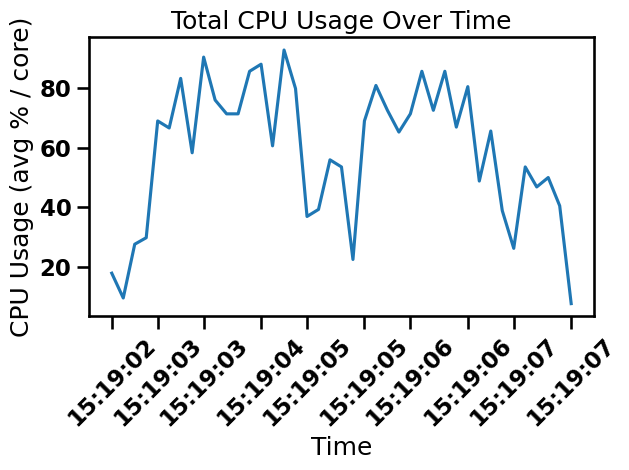

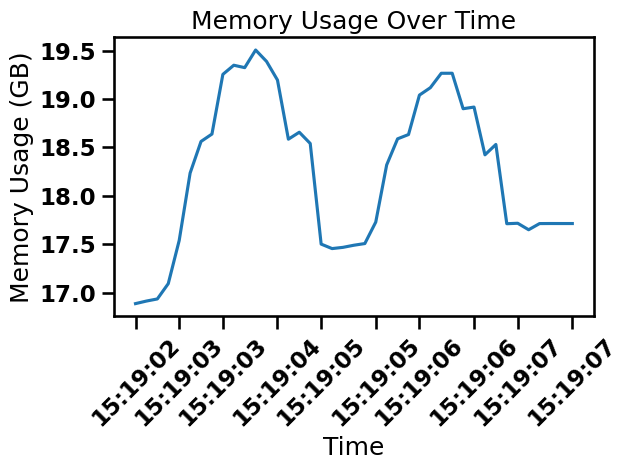

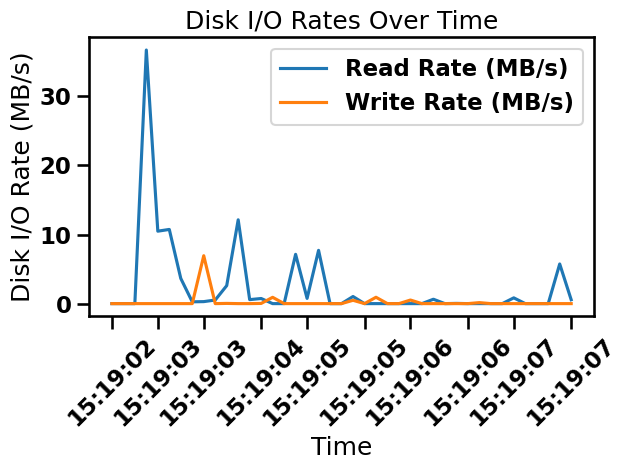

In [86]:
monitor.plot_metrics()

In [37]:
# add a little bit of noise to the test data because otherwise hvg selection evaluation has a problem with the same values
# test_adata2 = test_adata.copy()
# test_adata2.X += np.random.normal(0, 1e-10, size=test_adata2.X.shape)
# The fitted model can be used to create universial embeddings
encoder.load(file_path="best_encoder_weights.pth")
decoder.load(file_path="best_decoder_weights.pth")
trainer = Trainer(
    encoder=encoder, decoder=decoder, input_embeddings={"main": "data_embedding", "cross": "context_embedding"}
)
trainer.infer_adata(
    test_adata,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
)

mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_decoder_weights.pth


C:\Users\mengerj\repos\mmcontext\src\mmcontext\engine\trainer.py:603: ImplicitModificationWarning: Setting element `.obsm['mod_emb']` of view, initializing view as actual.
  # Now, update adata.obsm and adata.layers with the zarr arrays
... storing 'dataset_id' as categorical
... storing 'cell_type' as categorical


In [38]:
inferred_adata = anndata.read_zarr("inferred_adata.zarr")

#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [15]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata, batch_key="dataset_id", label_key="cell_type", embedding_key=["scvi", "mod_emb"]
)

In [ ]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=1)
monitor.start()

res = evaluator.evaluate()

monitor.stop()

mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate_scib - INFO - Computing PCA on all genes...
resolution: 0.1, nmi: 0.3417341533508329
resolution: 0.2, nmi: 0.45418854311371126
resolution: 0.3, nmi: 0.48491581059650535
resolution: 0.4, nmi: 0.5171217525137568
resolution: 0.5, nmi: 0.5623186135270241
resolution: 0.6, nmi: 0.6093633993984816
resolution: 0.7, nmi: 0.6059588618195648
resolution: 0.8, nmi: 0.606235985016033
resolution: 0.9, nmi: 0.6112902559222456
resolution: 1.0, nmi: 0.6213680045662596
resolution: 1.1, nmi: 0.6334694192563273
resolution: 1.2, nmi: 0.6319787545368796
resolution: 1.3, nmi: 0.6328498620806277
resolution: 1.4, nmi: 0.6425934044034364
resolution: 1.5, nmi: 0.6312924556982928
resolution: 1.6, nmi: 0.6296580719703679
resolution: 1.7, nmi: 0.6297329914309377
resolution: 1.8, nmi: 0.6296580719703679
resolution: 1.9, nmi: 0.6442702487979206
resolution: 2.0, nmi: 0.6415149951008575
optimised clustering against cell_type
o

We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data

In [30]:
from mmcontext.eval import compare_data_properties

# Assuming data1 and data2 are numpy arrays with your datasets
properties = compare_data_properties(
    inferred_adata.X.toarray(), inferred_adata.layers["reconstructed"], predefined_subset="microbiome"
)

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - ERROR - Error computing bimodalityColCorr: 'float' object has no attribute 'flatten'


C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:579: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(log2cpm, axis=0, ddof=1)
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:800: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_res, _ = scipy.stats.spearmanr(mtx_sub, axis=0)
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:392: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.


C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:579: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(log2cpm, axis=0, ddof=1)
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:392: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\en

In [32]:
properties["allLog2FC"]

{'LinearCoefPoly2XRowMeansLog2cpmYRowVarsLog2cpm': np.float64(-0.6654430548438326),
 'rowMediansLog2cpm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 800x800 with 0 Axes>

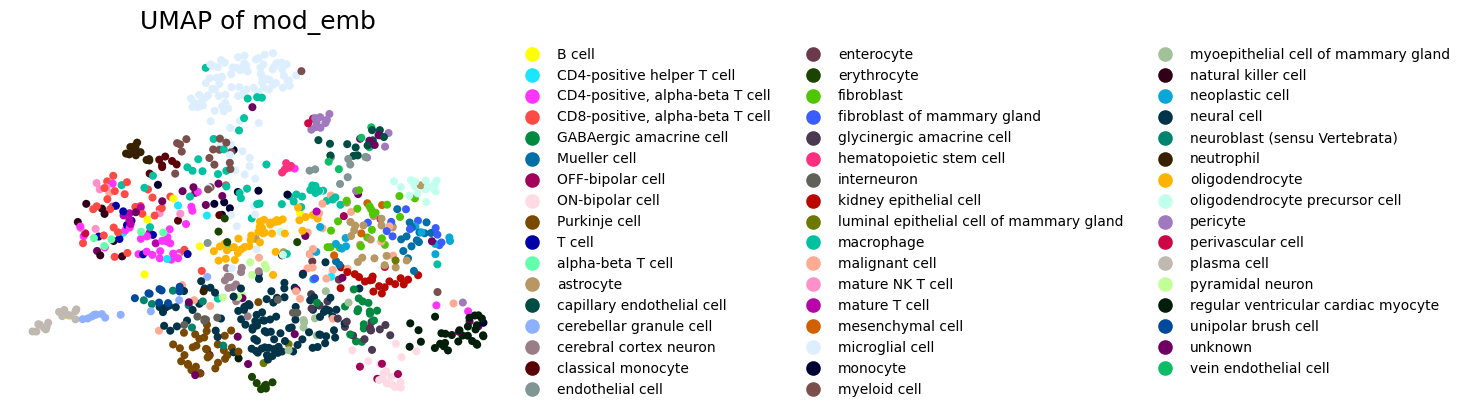

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [40]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

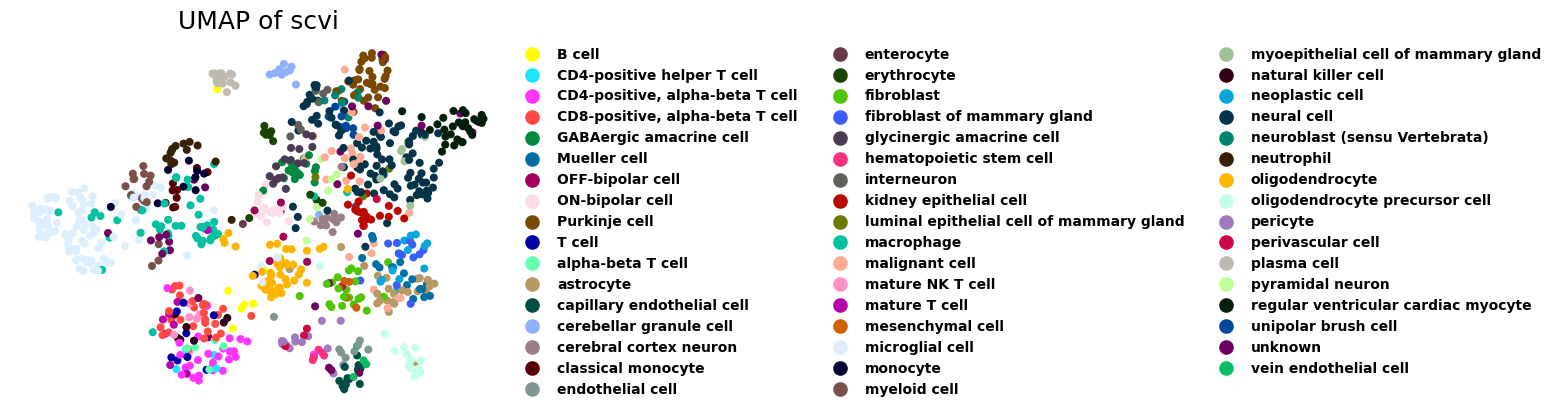

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [41]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="scvi", save_plot=False)